####**Music Recommendation System via Pearson Correlation & Collaborative Filtering**

**Contents:**


*   Objective
*   Data Pre-processing
*   Exploratory Data Analysis
*   Collaborative Filtering Recommendation System via Pearsons' R Correlation
*   Collaborative Filtering Recommendation System via Unsupervised KNN

**Objective**


*   Build music recommendation system by learning from data, and recommend music to users









In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

In [ ]:
# Display query output immediately

%%bigquery --project kumu-exam-348409
SELECT 
  COUNT(*) as total_rows
FROM `listenbrainz.listenbrainz.listen`
WHERE listened_at >= '2018-01-01 00:00:00+00:00'

,total_rows
0,5369140


In [ ]:
# Save output in a variable `df`

%%bigquery --project kumu-exam-348409 df
SELECT 
  COUNT(*) as total_rows
FROM `listenbrainz.listenbrainz.listen`
WHERE listened_at >= '2018-01-01 00:00:00+00:00'

In [ ]:
df

,total_rows
0,5369140


In [ ]:
project_id = 'kumu-exam-348409'

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 50000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `listenbrainz.listenbrainz.listen`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `listenbrainz.listenbrainz.listen`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 146914257 rows


A sample count of 50000 is set to get random 50000 sample data from the full dataset by using RAND(). 

The RAND() function generates a pseudo-random value of type FLOAT64 in the range of [0, 1), inclusive of 0 and exclusive of 1.

**Pre-processing**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

import requests
from io import StringIO

#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
#function to display dataframes side by side    
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px !important;margin-right: 40px !important"'),raw=True)

In [ ]:
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

In [ ]:
def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20)    

In [ ]:
# Filter 2018 data only

df_2018 = df.loc[(df['listened_at'] >= '2018-01-01 00:00:00+00:00')]
df_2018.head()

,listened_at,user_name,artist_msid,artist_name,artist_mbids,release_msid,release_name,release_mbid,recording_msid,track_name,recording_mbid,tags
1,2018-06-21 04:46:04+00:00,Kerenon,a33db12f-63f0-44ab-9c37-9f0cf60a1f2d,Madonna,,cd2739d6-0500-46bb-85ed-0a9a39d590b0,Confessions On A Dance Floor,,879a854e-f63d-4f48-b937-fe2e0822924e,How High,,
2,2018-05-03 00:38:30+00:00,tn5421,43f3de0d-672b-4d4e-ba97-941418b71335,The Used,,59f46b9a-f1e1-4cbf-8df0-692002c8ced3,Lies For The Liars (Explicit Version),,7f618717-d17a-4b94-ba20-af5e6ab73129,Pretty Handsome Awkward,08b106b0-f32b-409a-9dcf-36c38f32191a,
3,2018-04-26 17:54:05+00:00,tn5421,6f21a5f8-06d3-4060-a4bf-75d8acf5d32b,Simple Plan,,dd7b703a-6723-47a5-a5fb-f1e54b85e0a6,Still Not Getting Any,,ba5db196-a991-4291-9320-c7224b23aafb,Welcome to My Life,c3a027ab-15e9-44a9-af07-fe75f0b3d0fb,
4,2018-04-07 22:18:13+00:00,tn5421,5201944d-b08d-4cd6-a580-9cda7b7c9b60,Seether,,55127bc7-c665-4076-851d-92e04ce55051,Finding Beauty In Negative Spaces (Bonus Track...,,3637d044-ba05-4175-b654-37588dfc98e8,Fake It,0b5bf9ed-6748-45e8-b85e-f05a4af549d5,
5,2018-03-28 03:54:52+00:00,tn5421,093d1c46-f28c-427c-a521-c5abe25fa75d,Apoptygma Berzerk,,0bf09107-0f5a-4892-8160-28ffab4a62df,Welcome To Earth (Deluxe Bonus Track Edition) ...,,8cabdef1-8918-481a-abc8-899c3645c0a8,Starsign,af074d8c-a82f-4269-9224-d8812a21351c,


In [ ]:
save_df_2018 = df_2018.to_csv('pycaret_df_2018.csv', index=False)

After saving the filtered 2018 data to csv, listen_count.csv & songs.csv are made from the 2018 data. The listen_count column is an additional feature, listen_count column data is generated via Mockaroo, ranging from 1 to 25.

listen_count.csv contains the columns user_name, recording_msid, & listen_count.
songs.csv contains the columns recording_msid & track_name

**EDA** 

In [ ]:
from google.colab import files
#uploaded = files.upload()

In [ ]:
songs = pd.read_csv('songs.csv')
listen_count = pd.read_csv('listen_count.csv')

In [ ]:
songs.head()

,recording_msid,track_name
0,e0cf6252-af75-4d78-91b7-9741ce4a5dca,Whisper Diving
1,367fca69-71a7-4d9a-94ca-1181f2108110,My Friends Over You
2,62779893-6475-40fe-b399-390ce928ece4,Sonic Reducer
3,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In"
4,716029c0-f3eb-4b2b-8660-ba6882c8e7a0,You're Cute When You Scream


In [ ]:
listen_count.head()

,user_name,recording_msid,listen_count
0,consolejunkie,e0cf6252-af75-4d78-91b7-9741ce4a5dca,10
1,DJToxic420,367fca69-71a7-4d9a-94ca-1181f2108110,16
2,Bowtie,62779893-6475-40fe-b399-390ce928ece4,2
3,tn5421,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,13
4,tn5421,716029c0-f3eb-4b2b-8660-ba6882c8e7a0,19


In [ ]:
# Statistics of listen_count column

listen_count.describe()

,listen_count
count,1850.000000
mean,13.189730
std,7.198657
min,1.000000
25%,7.000000
50%,13.000000
75%,20.000000
max,25.000000


In [ ]:
# Information about listen_count.csv

listen_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_name       1850 non-null   object
 1   recording_msid  1850 non-null   object
 2   listen_count    1850 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.5+ KB


In [ ]:
# Information about songs.csv

songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   recording_msid  1850 non-null   object
 1   track_name      1850 non-null   object
dtypes: object(2)
memory usage: 29.0+ KB


In [ ]:
# Unique users and songs count

print('Total unique users in the dataset', listen_count['user_name'].nunique())
print('Total unique songs in the dataset', songs['track_name'].nunique())

Total unique users in the dataset 759
Total unique songs in the dataset 1826


Listen Count Distribution

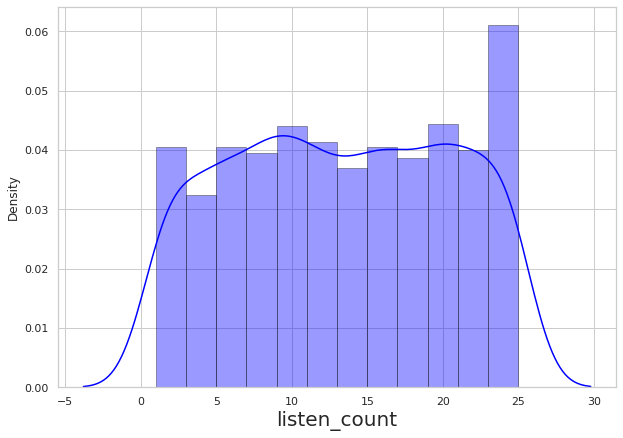

In [ ]:
pal = sns.color_palette(palette='Set1', n_colors=16)

distplot(1, 1, 10, 7, data=listen_count, features=['listen_count'], colors=['blue'])

*   Many users have listened multiple times to a song.
*   There is a spike at the end of the plot, which means that a high number of users have listened to songs way too much.




In [ ]:
merged_csv = pd.merge(songs, 
                    listen_count[['recording_msid', 'listen_count', 'user_name']],
                    on = 'recording_msid')
merged_csv.head(10)

,recording_msid,track_name,listen_count,user_name
0,e0cf6252-af75-4d78-91b7-9741ce4a5dca,Whisper Diving,10,consolejunkie
1,367fca69-71a7-4d9a-94ca-1181f2108110,My Friends Over You,16,DJToxic420
2,62779893-6475-40fe-b399-390ce928ece4,Sonic Reducer,2,Bowtie
3,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",13,tn5421
4,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",16,dak180
5,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",18,seminocturnal
6,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",3,AustinHogan777
7,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",12,iliekcomputers
8,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",16,wesmrqs
9,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",25,ReeseM


In [ ]:
# Remove duplicate rows from data where user_name and tracK_name have the same value (doing this will make listen count unique to every row)

drop_duplicates = merged_csv.drop_duplicates(subset=['user_name','track_name'], keep='first', inplace=True)
drop_duplicates

In [ ]:
merged_csv.shape

(1840, 4)

---

Listen Count Distribution grouped by Songs

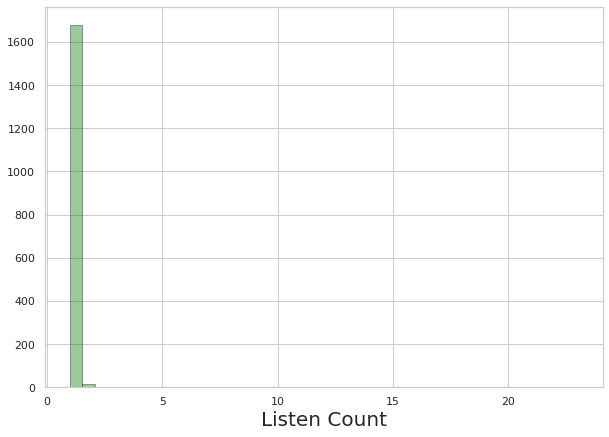

In [ ]:
groupby_songs_listen_count = merged_csv.groupby('track_name')['listen_count']

groupby_songs_listen_count.count().unique()

listen_count_songs = pd.DataFrame(groupby_songs_listen_count.count())#.clip(upper=30))
listen_count_songs.rename(columns={"listen_count": "Listen Count"}, inplace=True)

distplot(1, 1, 10, 7, data=listen_count_songs, features=['Listen Count'], colors=['green'], kde=False)

The graph is a listen count grouped by all the songs.

Based from the graph, a lot of songs which were listened to/played only once, i.e. only one user have listened to a song.

---

Listen Count Distribution grouped by Users

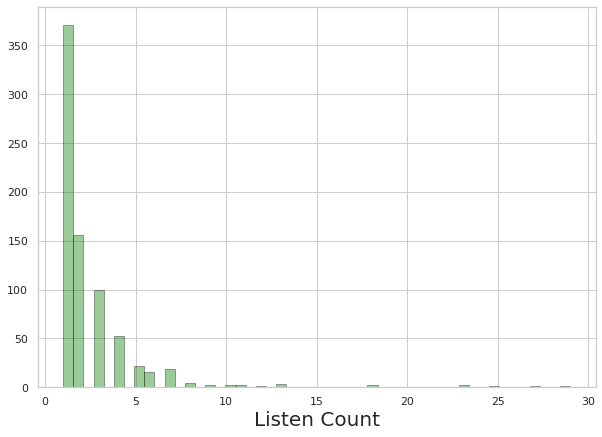

In [ ]:
groupby_users_listen_count = merged_csv.groupby('user_name')['listen_count']

groupby_users_listen_count.count().unique()

listen_count_users = pd.DataFrame(groupby_users_listen_count.count())#.clip(upper=30))
listen_count_users.rename(columns={"listen_count": "Listen Count"}, inplace=True)

distplot(1, 1, 10, 7, data=listen_count_users, features=['Listen Count'], colors=['green'], kde=False)

The graph is a listen count grouped by all the users.

Based from the graph, a lot of users have listened to songs/played once or below. Listen count by users decreases which means few users have listened to many songs.



---

Mean Rating Distribution grouped by Songs

Mean Listen Count : 13.19836956521739


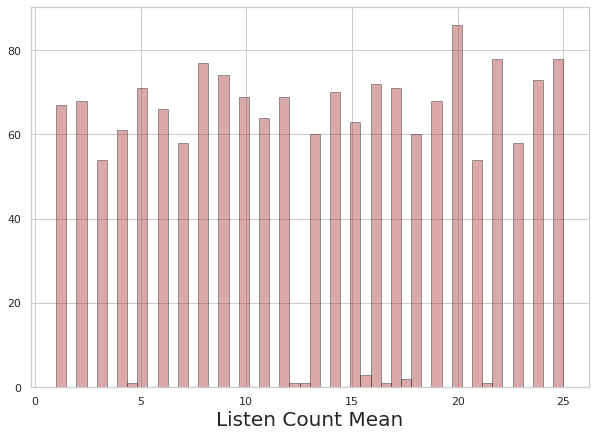

In [ ]:
mean_listen_count_songs = pd.DataFrame(merged_csv.groupby('track_name')['listen_count'].mean())
mean_listen_count_songs.rename(columns={"listen_count": "Listen Count Mean"}, inplace=True)

distplot(1, 1, 10, 7, data=mean_listen_count_songs, features=['Listen Count Mean'], colors=['brown'], kde=False, bins=50)
print("Mean Listen Count :", merged_csv['listen_count'].mean())

The graph is a mean listen count distribution grouped by songs.

Based from the graph, some songs are played below the mean listen count, and some songs are played beyond the mean listen count.

---

Mean Rating Distribution grouped by Users

Mean Listen Count : 13.19836956521739


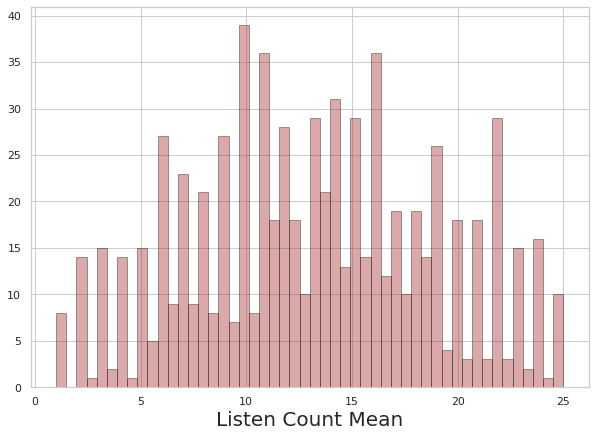

In [ ]:
mean_listen_count_users = pd.DataFrame(merged_csv.groupby('user_name')['listen_count'].mean())
mean_listen_count_users.rename(columns={"listen_count": "Listen Count Mean"}, inplace=True)

distplot(1, 1, 10, 7, data=mean_listen_count_users, features=['Listen Count Mean'], colors=['brown'], kde=False, bins=50)
print("Mean Listen Count :", merged_csv['listen_count'].mean())

The graph is a mean rating distribution grouped by all the users.

Based from the graph, data is concentratedly distributed from listen count 5 to 20. Huge number of users have an average listen count of around 12 (12 is achieved by getting the average of 5 and 20).

---

Collaborative Filtering (Pearons' R Correlation)

> Collaborative Filtering (or User-User Filtering) is a technique that uses other users to recommend songs to the input user. It attempts to find users that have similar preferences as the input, and then recommends songs that they have listened to to the input. Via Pearson Correlation Function, collaborative filtering is feasible.

> The process is as follows:



>*   Select a user with the songs the user has listened to.
*   Based on his listen count to songs, find the top X neighbors.
*   Get the played song list of the user for each neighbor.
*   Calculate a similarity.
*   Recommend the songs with the highest importance/score.

In [ ]:
# tn5421 is the selected user, user_name = tn5421

user = [
          {'track_name' : 'Dear Maria, Count Me In', 'listen_count' : 13},
          {'track_name' : "You're Cute When You Scream", 'listen_count' : 19},
          {'track_name' : 'Under Pressure', 'listen_count' : 8},
          {'track_name' : 'Champagne for My Real Friends, Real Pain for My Sham Friends', 'listen_count' : 17},
          {'track_name' : 'Disenchanted', 'listen_count' : 1},
          {'track_name' : 'Get Busy Living or Get Busy Dying (Do Your Part to Save the Scene and Stop Going to Shows)', 'listen_count' : 1},
          {'track_name' : 'The Bird And The Worm', 'listen_count' : 11}
]
inputSongs = pd.DataFrame(user)
inputSongs

,track_name,listen_count
0,"Dear Maria, Count Me In",13
1,You're Cute When You Scream,19
2,Under Pressure,8
3,"Champagne for My Real Friends, Real Pain for M...",17
4,Disenchanted,1
5,Get Busy Living or Get Busy Dying (Do Your Par...,1
6,The Bird And The Worm,11


In [ ]:
# Filtering out the songs by track name

Id = songs[songs['track_name'].isin(inputSongs['track_name'].tolist())]

# then merging it so we can get the recording_msid. It's implicitly merging it by track_name.

inputSongs = pd.merge(Id, inputSongs)

In [ ]:
# Filtering out users that have played songs that the input has watched and storing it

users = listen_count[listen_count['recording_msid'].isin(inputSongs['recording_msid'].tolist())]
users.head()

,user_name,recording_msid,listen_count
3,tn5421,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,13
4,tn5421,716029c0-f3eb-4b2b-8660-ba6882c8e7a0,19
5,tn5421,be77b80a-34cd-4529-8acb-762fd00d06b9,8
6,tn5421,46b323fd-ecd6-4bd6-9b2e-30328857ddd3,17
7,tn5421,3988122c-87fb-4284-b07e-2b4090ae0284,1


CAVEAT: Upon prior checking, the initial data does not have much similar users listening to same songs which means lack of similarity, there could potentially be much more similar users listening to same songs if there are more data. Thus, for this project, duplication of songs and matching it to random users has to be done in order for similarity to exist.

Moreover, determining the sample sizes involve resource and statistical issues. Usually, researchers regard 100 participants as the minimum sample size when the population is large (Alshibly, 2016). Therefore, a minimum of 100 users were randomly selected to match the similar songs of the chosen user.

Source: https://www.researchgate.net/post/What-is-the-sample-size-for-correlation-coefficients:

In [ ]:
users.shape

(138, 3)

We can see from the result above that there are 138 users who have similar songs with the chosen user.

In [ ]:
# Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter

userSubsetGroup = users.groupby(['user_name'])

In [ ]:
# Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

In [ ]:
userSubsetGroup[0:3]

[('tn5421',   user_name                        recording_msid  listen_count
  3    tn5421  5d107b2e-0e40-4428-9eec-fc8c4f0a50a7            13
  4    tn5421  716029c0-f3eb-4b2b-8660-ba6882c8e7a0            19
  5    tn5421  be77b80a-34cd-4529-8acb-762fd00d06b9             8
  6    tn5421  46b323fd-ecd6-4bd6-9b2e-30328857ddd3            17
  7    tn5421  3988122c-87fb-4284-b07e-2b4090ae0284             1
  8    tn5421  a6acc39b-04d7-40f5-b6fa-80800f4b8289             1
  9    tn5421  288cb6cc-b92a-4582-a838-91492c60e270            11),
 ('dak180',     user_name                        recording_msid  listen_count
  249    dak180  a6acc39b-04d7-40f5-b6fa-80800f4b8289            15
  250    dak180  5d107b2e-0e40-4428-9eec-fc8c4f0a50a7            16
  251    dak180  3988122c-87fb-4284-b07e-2b4090ae0284             6
  252    dak180  3988122c-87fb-4284-b07e-2b4090ae0284            11
  254    dak180  46b323fd-ecd6-4bd6-9b2e-30328857ddd3            21),
 ('Silent Singer',
           user_name 

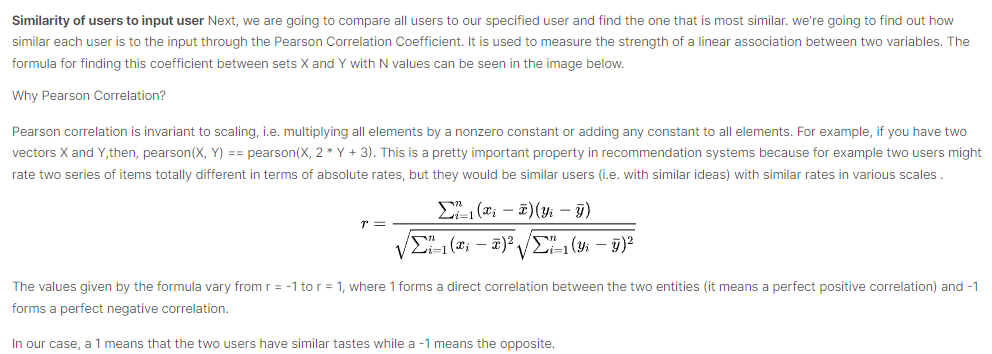

In [ ]:
# Store the Pearson Correlation in a dictionary, where the key is the user id and the value is the coefficient
pearsonCorDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    # Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='recording_msid')
    inputSongs = inputSongs.sort_values(by='recording_msid')
    # Get the N for the formula
    n = len(group)
    # Get the listen count for the songs that they both have in common
    temp = inputSongs[inputSongs['recording_msid'].isin(group['recording_msid'].tolist())]
    # And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp['listen_count'].tolist()
    # Put the current user group listen count in a list format
    tempGroupList = group['listen_count'].tolist()
    # Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(n)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(n)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorDict[name] = 0

In [ ]:
pearsonCorDict.items()

dict_items([('tn5421', 1.0), ('dak180', 0.22458533969282252), ('Silent Singer', 0.1945374212149722), ('dhedol', -0.5000000000000001), ('ngk', 0.40964401518645693), ('spl0k', 0.42405866445383006), ('xy7i', -0.9113933613140028), ('AustinHartman', 1.0), ('Didcrywolf1', -1.0), ('KryptoN', 1.0), ('MadLostSoul', 1.0), ('Mandelmuster', -1.0), ('ReeseM', 1.0), ('TurbinoZ100000', -1.0), ('fru1tstand', 1.0), ('prizefyter', 1.0), ('voitila', 0), ('vonbernburg', -1.0), ('Adsky_traktor', 0), ('Aeoris', 0), ('Arcor', 0), ('August Janse', 0), ('AustinHogan777', 0), ('DCCXX', 0), ('Dark5lalom', 0), ('Dark_Ronius', 0), ('Disfigurator', 0), ('Flamingozilla', 0), ('Freshman47', 0), ('G4Zz0L1', 0), ('Goyatuzo', 0), ('HMoradpour73', 0), ('IICUX', 0), ('Javiermed', 0), ('Joshkunz', 0), ('Kanau', 0), ('KravenJames', 0), ('LGPoK', 0), ('LemanSachs', 0), ('LiiJit', 0), ('Madoushi', 0), ('Moebeus', 0), ('MrLitopysec', 0), ('PoVa', 0), ('Reisen Udongein Inaba', 0), ('Saul239', 0), ('Unfoldingdrama', 0), ('Woyken

In [ ]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['user_name'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,user_name
0,1.000000,tn5421
1,0.224585,dak180
2,0.194537,Silent Singer
3,-0.500000,dhedol
4,0.409644,ngk


In [ ]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,user_name
0,1.0,tn5421
7,1.0,AustinHartman
15,1.0,prizefyter
14,1.0,fru1tstand
12,1.0,ReeseM


Rating of selected users to all songs
> The rating of selected users to all songs is done by taking the weighted average of the ratings of the songs using the Pearson Correlation as the weight. However, the songs played/listend to by the users in the pearsonDF from the ratings dataframe have to be got, and then store their correlation in a new column called _similarityIndex. This is achieved below by merging of these two tables.

In [ ]:
topUsersRating=topUsers.merge(listen_count, left_on='user_name', right_on='user_name', how='inner')
topUsersRating.head()

,similarityIndex,user_name,recording_msid,listen_count
0,1.0,tn5421,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,13
1,1.0,tn5421,716029c0-f3eb-4b2b-8660-ba6882c8e7a0,19
2,1.0,tn5421,be77b80a-34cd-4529-8acb-762fd00d06b9,8
3,1.0,tn5421,46b323fd-ecd6-4bd6-9b2e-30328857ddd3,17
4,1.0,tn5421,3988122c-87fb-4284-b07e-2b4090ae0284,1


In [ ]:
# Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['listen_count']
topUsersRating.head()

,similarityIndex,user_name,recording_msid,listen_count,weightedRating
0,1.0,tn5421,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,13,13.0
1,1.0,tn5421,716029c0-f3eb-4b2b-8660-ba6882c8e7a0,19,19.0
2,1.0,tn5421,be77b80a-34cd-4529-8acb-762fd00d06b9,8,8.0
3,1.0,tn5421,46b323fd-ecd6-4bd6-9b2e-30328857ddd3,17,17.0
4,1.0,tn5421,3988122c-87fb-4284-b07e-2b4090ae0284,1,1.0


In [ ]:
# Applies a sum to the topUsers after grouping it up by song id
tempTopUsersRating = topUsersRating.groupby('recording_msid').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
recording_msid,,
02beb4b2-ce5c-4590-88f1-944723e61c66,0.000000,0.000000
04428b18-41c5-4d05-8b77-455b0412e945,0.000000,0.000000
06b2c05a-5b13-4733-8247-8ae75a50f6e3,0.000000,0.000000
0f38d480-b13b-4125-bbfd-a221a7ce66da,0.224585,1.122927
10670e4f-5a49-4b7f-a667-a7975909e33a,0.000000,0.000000


In [ ]:
# Create empty dataframe
recommendation_df = pd.DataFrame()
# Take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['song_id'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,song_id
recording_msid,,
02beb4b2-ce5c-4590-88f1-944723e61c66,NaN,02beb4b2-ce5c-4590-88f1-944723e61c66
04428b18-41c5-4d05-8b77-455b0412e945,NaN,04428b18-41c5-4d05-8b77-455b0412e945
06b2c05a-5b13-4733-8247-8ae75a50f6e3,NaN,06b2c05a-5b13-4733-8247-8ae75a50f6e3
0f38d480-b13b-4125-bbfd-a221a7ce66da,5.0,0f38d480-b13b-4125-bbfd-a221a7ce66da
10670e4f-5a49-4b7f-a667-a7975909e33a,NaN,10670e4f-5a49-4b7f-a667-a7975909e33a


In [ ]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,song_id
recording_msid,,
f9c80391-7c4c-4bab-a5a1-520d902c05de,25.0,f9c80391-7c4c-4bab-a5a1-520d902c05de
e86a7730-7521-4be1-9fbe-62718fa18599,25.0,e86a7730-7521-4be1-9fbe-62718fa18599
bd012116-8ec3-42fc-94b8-0d3400df33a8,24.0,bd012116-8ec3-42fc-94b8-0d3400df33a8
23b4f3d1-8ed4-4ca4-b123-2515c7f2d99f,23.0,23b4f3d1-8ed4-4ca4-b123-2515c7f2d99f
9da2888c-1042-47b3-91fd-993cbcbdd3d9,23.0,9da2888c-1042-47b3-91fd-993cbcbdd3d9
e2081042-8b3d-44e0-b71a-a3ddedc72330,22.0,e2081042-8b3d-44e0-b71a-a3ddedc72330
e33512ad-7769-4a55-8488-e3feb76bdcca,21.0,e33512ad-7769-4a55-8488-e3feb76bdcca
bebca611-e579-438b-9712-d8fd9b12ee45,20.0,bebca611-e579-438b-9712-d8fd9b12ee45
93e5685f-ce09-41b7-834c-5be96a3e6fe4,20.0,93e5685f-ce09-41b7-834c-5be96a3e6fe4


In [ ]:
# Make recommendation.

id_songs = pd.merge(songs, 
                    recommendation_df[['song_id']],
                    on = 'recording_msid')
id_songs.head(10)

,recording_msid,track_name,song_id
0,5d107b2e-0e40-4428-9eec-fc8c4f0a50a7,"Dear Maria, Count Me In",5d107b2e-0e40-4428-9eec-fc8c4f0a50a7
1,716029c0-f3eb-4b2b-8660-ba6882c8e7a0,You're Cute When You Scream,716029c0-f3eb-4b2b-8660-ba6882c8e7a0
2,be77b80a-34cd-4529-8acb-762fd00d06b9,Under Pressure,be77b80a-34cd-4529-8acb-762fd00d06b9
3,46b323fd-ecd6-4bd6-9b2e-30328857ddd3,"Champagne for My Real Friends, Real Pain for M...",46b323fd-ecd6-4bd6-9b2e-30328857ddd3
4,3988122c-87fb-4284-b07e-2b4090ae0284,Disenchanted,3988122c-87fb-4284-b07e-2b4090ae0284
5,a6acc39b-04d7-40f5-b6fa-80800f4b8289,Get Busy Living or Get Busy Dying (Do Your Par...,a6acc39b-04d7-40f5-b6fa-80800f4b8289
6,288cb6cc-b92a-4582-a838-91492c60e270,The Bird And The Worm,288cb6cc-b92a-4582-a838-91492c60e270
7,78547dcb-f934-4dc0-adfb-6915326d54da,The Way You Do the Things You Do,78547dcb-f934-4dc0-adfb-6915326d54da
8,c3c14852-b3e5-46f0-af22-46af87685198,Boy In A Dress,c3c14852-b3e5-46f0-af22-46af87685198
9,ee214ea6-481b-48db-bd73-54efbce075c8,No Matter,ee214ea6-481b-48db-bd73-54efbce075c8


Collaborative Filtering Recommendation System via Unsupervised KNN

We are combining two dataframe (songs and listen count) and are creating songs vs user matrix.

In [ ]:
#data = pd.merge(songs, listen_count)
song_pivot=data.pivot_table(index='user_name',columns='track_name',values='listen_count').fillna(0)

In [ ]:
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(n_neighbors=10,metric='cosine')
Model=knn.fit(song_pivot)

In [ ]:
song_pivot=data.pivot_table(index='user_name',columns='track_name',values='listen_count').fillna(0)

In [ ]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(song_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
query_index = np.random.choice(song_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(song_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

490


In [ ]:
song_pivot.head()

track_name,"""Ajde Jano"", Tradicional","""Heroes"" (2017 Remastered Version)",#5,#NAME?,'70: They're Killing Children Over There,'Tis a Pity She Was a Whore,(Encuentro),(Fuck A) Silver Lining,(I Canâ€™t Get No) Satisfaction - Mono / Remastered,(spiral),...,çœŸå¤œä¸­ã®ã‚¨ãƒƒã‚»ã‚¤,è–ãªã‚‹å¤¢ I,èª°ã‹ã€æµ·ã‚’ã€‚,èŒœã•ã™,è‡ªç”±ã®ä»£å„Ÿ,é¢¨è‰²ãƒ¡ãƒ­ãƒ‡ã‚£,é€åŽ»æ—¥å­,ë¹¨ê°„ ë§› Red Flavor,ë¹„ëŠ˜,ì•„ê¹Œì›Œ
user_name,,,,,,,,,,,,,,,,,,,,,
-andor-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0lpbm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3c5t1n0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400GBofRAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AcidLilium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Top 5 Recommendations for {0}:\n'.format(song_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, song_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Top 5 Recommendations for liDEL:

1: maddanio, with distance of 1.0:
2: maanwel, with distance of 1.0:
3: magsati, with distance of 1.0:
4: magic_robot_brain, with distance of 1.0:
5: mamukun730, with distance of 1.0:


Check the songs of the top 5 users to check what songs are recommended.

In [ ]:
merged_csv[merged_csv['user_name'] == 'maddanio']

,recording_msid,track_name,listen_count,user_name
874,21bd91ec-2682-48ec-a1a5-fde43048b092,Don't Wanna,16,maddanio


In [ ]:
merged_csv[merged_csv['user_name'] == 'maanwel']

,recording_msid,track_name,listen_count,user_name
111,a6acc39b-04d7-40f5-b6fa-80800f4b8289,Get Busy Living or Get Busy Dying (Do Your Par...,22,maanwel


In [ ]:
merged_csv[merged_csv['user_name'] == 'magsati']

,recording_msid,track_name,listen_count,user_name
641,f2801dda-1aec-440e-845c-f2434f17acd9,Smokey Day,1,magsati


In [ ]:
merged_csv[merged_csv['user_name'] == 'magic_robot_brain']

,recording_msid,track_name,listen_count,user_name
985,f30d3fdc-0cfe-4093-b8bb-1cb96275d2b6,Immortality (Remastered),24,magic_robot_brain
1004,7dedd644-f4b4-473f-9f11-af27f5bb8f07,State of Love and Trust,20,magic_robot_brain
1272,860da081-e7c1-434e-8c68-ecc0120e9cdb,Commissioning a Symphony In C,15,magic_robot_brain


In [ ]:
merged_csv[merged_csv['user_name'] == 'mamukun730']

,recording_msid,track_name,listen_count,user_name
1241,10f70c68-e943-43d3-b545-1718bf066019,The Star-Spangled Banner -solo-,17,mamukun730


Pearson's R Coefficient is used because it is a very yet effective way to find how a variable linearly changes with respect to another. Unsupervised KNN is utilized because it is also a simple yet effective algorithm to interpret, as it finds clusters of similar users based on values, and make predictions using the average rating of top-k nearest neighbors.

We now have generated song recommendations via Pearson's R and Unsupervised KNN. Pearson's R Correlation does not have evaluation metrics since it is a measure of linear correlation between two sets of data, and given that we used unsupervised knn learning it does not usually involve evaluation metrics.

